# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [11]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (A - D) \qquad \text{and} \qquad c = D^{-1} b
$$

__<font color='red'>Crash! B is not correct!</font>__


![Minion](https://octodex.github.com/images/dojocat.jpg)


$$
B = D^{-1} (D - A)
$$

Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [88]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)
invD = np.diag(1./diag_1d)
BB = invD @ B 
c = invD @ b

In [89]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [90]:
np.linalg.norm(BB)

0.36436161983015336

### Do the Jacobi iteration

In [91]:
n_iter = 50

x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

## My improvement
If we represent $A = D + \Lambda$, we can get formal solution:
$$
x = A^{-1}b = (D + \Lambda)^{-1}b = (D\cdot(I + D^{-1}\Lambda)^{-1}b = (I - D^{-1}\Lambda + ..)\cdot D^{-1}b
$$
Thus we are getting first approximation $x_1$ 
Conseqntmetly, $$x_0 = c$$


In [92]:
xmy = BB @ c + c
print('Solution', x)
print('My first iteration', xmy)
print('|x_{my} - x|',np.linalg.norm(x-xmy))
print('|x_{my} - x_1|', np.linalg.norm(xmy-(BB @ x0 + c)))

Solution [[ 0.03919429  0.03919429  0.03919429  0.03919429  0.03919429  0.03919429
   0.03919429  0.03919429  0.03919429  0.03919429]
 [ 0.03780037  0.03780037  0.03780037  0.03780037  0.03780037  0.03780037
   0.03780037  0.03780037  0.03780037  0.03780037]
 [ 0.04283232  0.04283232  0.04283232  0.04283232  0.04283232  0.04283232
   0.04283232  0.04283232  0.04283232  0.04283232]
 [ 0.02365951  0.02365951  0.02365951  0.02365951  0.02365951  0.02365951
   0.02365951  0.02365951  0.02365951  0.02365951]
 [ 0.05745031  0.05745031  0.05745031  0.05745031  0.05745031  0.05745031
   0.05745031  0.05745031  0.05745031  0.05745031]
 [-0.00030244 -0.00030244 -0.00030244 -0.00030244 -0.00030244 -0.00030244
  -0.00030244 -0.00030244 -0.00030244 -0.00030244]
 [-0.00577279 -0.00577279 -0.00577279 -0.00577279 -0.00577279 -0.00577279
  -0.00577279 -0.00577279 -0.00577279 -0.00577279]
 [ 0.03177549  0.03177549  0.03177549  0.03177549  0.03177549  0.03177549
   0.03177549  0.03177549  0.03177549  0.0

In [93]:
# Check the result:

A @ x - b

array([[ 1.11022302e-16,  1.11022302e-16,  1.11022302e-16,
         1.11022302e-16,  1.11022302e-16,  1.11022302e-16,
         1.11022302e-16,  1.11022302e-16,  1.11022302e-16,
         1.11022302e-16],
       [ 1.11022302e-16,  1.11022302e-16,  1.11022302e-16,
         1.11022302e-16,  1.11022302e-16,  1.11022302e-16,
         1.11022302e-16,  1.11022302e-16,  1.11022302e-16,
         1.11022302e-16],
       [-2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
        -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
        -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
        -2.22044605e-16],
       [ 1.11022302e-16,  1.11022302e-16,  1.11022302e-16,
         1.11022302e-16,  1.11022302e-16,  1.11022302e-16,
         1.11022302e-16,  1.11022302e-16,  1.11022302e-16,
         1.11022302e-16],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


In [94]:
    def jacobi_solution(A, b, n_iter = 15):
        diag_1d = np.diag(A)
        B = -A.copy()
        np.fill_diagonal(B, 0)

        D = np.diag(diag_1d)
        invD = np.diag(1./diag_1d)
        B = invD @ B 
        c = invD @ b
        
        x = c
        for _ in range(n_iter):
            x = B @ x + c
        return x

In [95]:
test = jacobi_solution(A,b,25)
print(np.linalg.norm(test-xx))

rndm = np.random.RandomState(1488)

n = 10
A_test = rndm.uniform(size=(n, n))
b_test = rndm.uniform(size=n)
x_test = jacobi_solution(A_test, b_test, 25)
print(A_test @ x_test - b_test)

2.397582587887413e-15
[-7.52378901e+29 -5.51006433e+29 -5.15519979e+29 -3.88306315e+29
 -3.23568376e+29 -4.77530047e+29 -6.92027002e+29 -6.17662403e+29
 -7.77904800e+29 -6.80397901e+29]


In [96]:
    def jacobi_solution(A, b, n_iter = 15):
        diag_1d = np.diag(A)
        B = -A.copy()
        np.fill_diagonal(B, 0)

        D = np.diag(diag_1d)
        invD = np.diag(1./diag_1d)
        B = invD @ B 
        c = invD @ b
        norm = np.linalg.norm(B)
        if norm > 1 - 1e-15:
            print('You are trying use Jacobi for non-diagol-dominant matrix, norm B = ', norm)
            a = 1/0
        x = c
        for _ in range(n_iter):
            x = B @ x + c
        return x

In [97]:

rndm = np.random.RandomState(1488)

n = 10
A_test = rndm.uniform(size=(n, n))
b_test = rndm.uniform(size=n)
x_test = jacobi_solution(A_test, b_test, 25)

You are trying use Jacobi for non-diagol-dominant matrix, norm B =  22.480213997525233


ZeroDivisionError: division by zero

# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

Working formule:
$$
(D+L)x_{n+1} = b - U x_{n}
$$

In [98]:
def seidel(A, b, n_iter=15):
    d = np.diag(A)
    D = np.diag(d)
    a = A - D
    L = np.tril(a)
    U = a - L
    G = D + L
    x0 = np.diag(1./d) @ b
    x = x0
    for _ in range(n_iter):
        c = b - U @ x
        x = get_next(G, c)
        #print(x)
    return x

In [99]:
def get_next(G, c):
    x = np.zeros(G.shape[0])
    for i in range(G.shape[0]):
        x[i] = (c[i] - G[i,:] @ x) / G[i,i]
    return x

In [100]:
rndm = np.random.RandomState(1488)

n = 10
A_t = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b_t = rndm.uniform(size=n)
x_t = seidel(A_t, b_t, 10)

In [101]:
A_t @ x_t - b_t

array([-1.73028258e-13, -9.61453139e-14, -8.02691247e-14, -3.14193116e-14,
       -8.04911693e-16,  3.88578059e-15,  2.13162821e-14,  7.46624984e-15,
        9.88098492e-15,  0.00000000e+00])

# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

## Constructing plan
Consider image, has non-movement point in solution our equation:
$$
\varphi(x) = x - \alpha \cdot r(x),
$$
where $r(x) = A x - b$ and $\alpha$ - some real number.
Then we are make iteration machine:
$$x_{n+1} = \varphi(x_n)$$
with dependecy $\alpha(n)$.

To minimization error $r_{n+1}$ we should to pick $$\alpha_n = \frac{(A r_n, r_n)}{(A r_n, A r_n)}$$

In [54]:
def res(A, b, x0 = None, n_iter=15):
    if x0 is None:
        x0 = np.ones(b.shape[0])
    
    x = x0
    
    for _ in range(n_iter):
        r = A @ x - b 
        #print(np.linalg.norm(r))
        a =  (r @ A.dot(r)) / (A.dot(r) @ A.dot(r))
        x = x  - a * r
    return x 

<IPython.core.display.Javascript object>


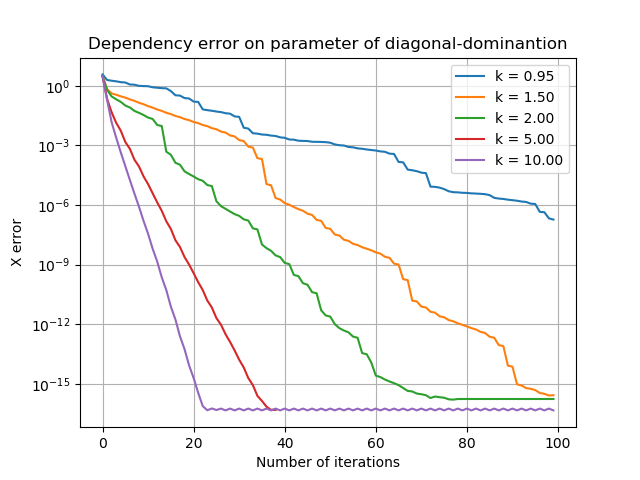

/home/maxkway/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [125]:
import matplotlib.pyplot as plt
%matplotlib notebook
rndm = np.random.RandomState(999)
plt.figure()

n = 10

for k in (0.95, 1.5, 2, 5, 10):
    A_r = rndm.uniform(size=(n, n)) + np.diagflat([k]*n)
    b_r = rndm.uniform(size=n)
    N = 100
    x_r = np.zeros((N, n))
    x_r[0] = np.ones(n)
    x_true = np.linalg.solve(A_r, b_r)
    errx = np.ones(N)
    errr = np.ones(N)
    errx[0] = np.linalg.norm(x_r[0] - x_true)
    errr[0] = np.linalg.norm(A_r @ x_r[0] - b_r )
    
    for i in range(1,N):
        x_r[i] = res(A_r, b_r, x0=x_r[i-1], n_iter=1)
        errx[i] = np.linalg.norm(x_r[i] - x_true)
        errr[i] = np.linalg.norm(A_r @ x_r[i] - b_r )
    plt.plot(errx, label = r'k = %.2f' % k)
    #plt.plot(errr)
plt.legend()    
plt.grid()
plt.xlabel('Number of iterations')
plt.ylabel('X error')
plt.title('Dependency error on parameter of diagonal-dominantion')
plt.yscale ('log', subsy=[2, 5])    

<IPython.core.display.Javascript object>


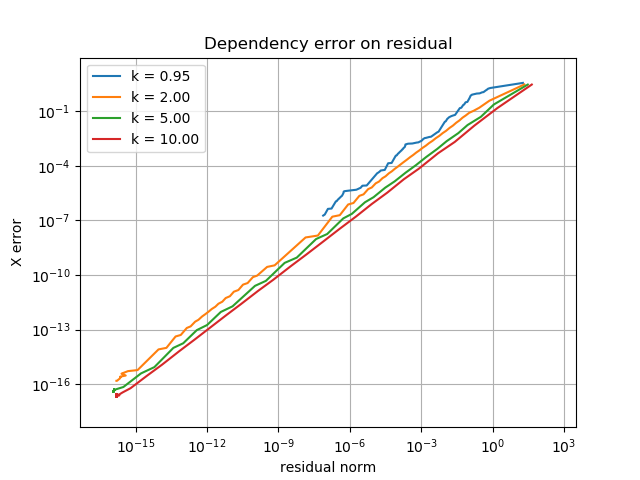

In [128]:
import matplotlib.pyplot as plt
%matplotlib notebook
rndm = np.random.RandomState(999)
plt.figure()

n = 10

for k in (0.95, 2, 5, 10):
    A_r = rndm.uniform(size=(n, n)) + np.diagflat([k]*n)
    b_r = rndm.uniform(size=n)
    N = 100
    x_r = np.zeros((N, n))
    x_r[0] = np.ones(n)
    x_true = np.linalg.solve(A_r, b_r)
    errx = np.ones(N)
    errr = np.ones(N)
    errx[0] = np.linalg.norm(x_r[0] - x_true)
    errr[0] = np.linalg.norm(A_r @ x_r[0] - b_r )
    
    for i in range(1,N):
        x_r[i] = res(A_r, b_r, x0=x_r[i-1], n_iter=1)
        errx[i] = np.linalg.norm(x_r[i] - x_true)
        errr[i] = np.linalg.norm(A_r @ x_r[i] - b_r )
    plt.plot(errr, errx, label = r'k = %.2f' % k)
plt.legend()
plt.grid()
plt.xlabel('residual norm')
plt.ylabel('X error')
plt.title('Dependency error on residual')
plt.yscale ('log', subsy=[2, 5])
plt.xscale ('log')    

<IPython.core.display.Javascript object>


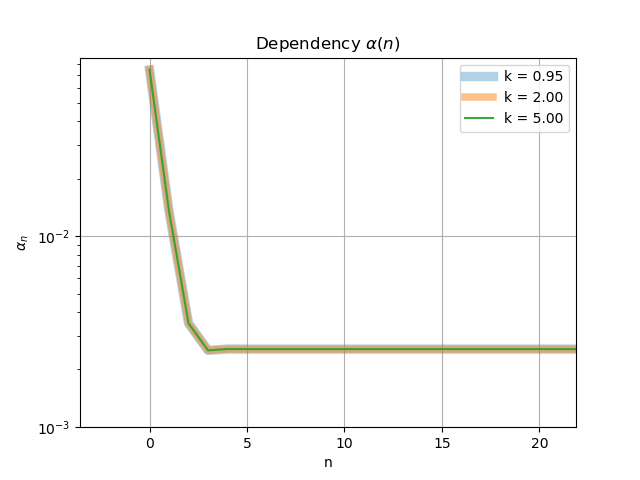

In [170]:
import matplotlib.pyplot as plt
%matplotlib notebook
def res_a(A, b, x0 = None, n_iter=15):
    if x0 is None:
        x0 = np.ones(b.shape[0])
    
    x = x0
    
    for _ in range(n_iter):
        r = A @ x - b 
        #print(np.linalg.norm(r))
        a =  (r @ A.dot(r)) / (A.dot(r) @ A.dot(r))
        x = x  - a * r
    return (x, a)


rndm = np.random.RandomState(999)
A_r = rndm.uniform(size=(n, n)) + np.diagflat([k]*n)
b_r = rndm.uniform(size=n)
N = 100
plt.figure()

n = 10

for k in (0.95, 2, 5):

    x_r = np.zeros((N, n))
    x_r[0] = np.ones(n)
    x_true = np.linalg.solve(A_r, b_r)
    errx = np.ones(N)
    a = np.ones(N-1)
    errx[0] = np.linalg.norm(x_r[0] - x_true)
    errr[0] = np.linalg.norm(A_r @ x_r[0] - b_r )
    
    for i in range(1,N):
        x_r[i] = res(A_r, b_r, x0=x_r[i-1], n_iter=1)[0]
        a[i-1] = res(A_r, b_r, x0=x_r[i-1], n_iter=1)[1]
        errx[i] = np.linalg.norm(x_r[i] - x_true)
        errr[i] = np.linalg.norm(A_r @ x_r[i] - b_r )
    
    plt.plot(a, label = r'k = %.2f' % k, alpha=0.2 + k/7, lw=8 - 1.3*k)


plt.legend()
plt.grid()
plt.xlabel('n')
plt.ylabel(r'$\alpha_n$')
plt.title(r'Dependency $\alpha(n)$')
plt.yscale ('log') 

<IPython.core.display.Javascript object>


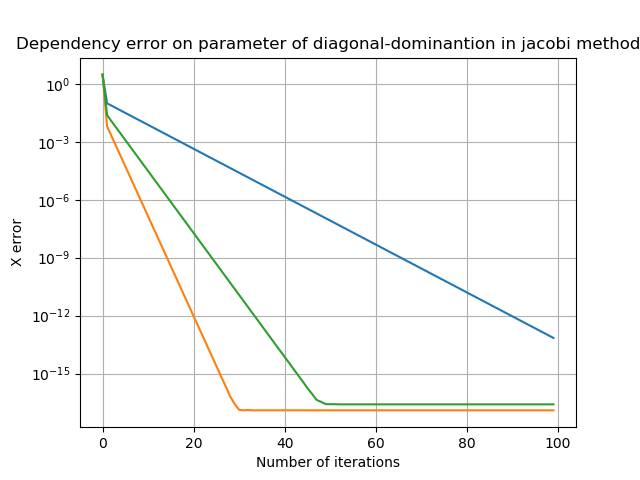

In [172]:
import matplotlib.pyplot as plt
%matplotlib notebook
rndm = np.random.RandomState(999)
plt.figure()

n = 10

for k in (6, 15,9):
    A_r = rndm.uniform(size=(n, n)) + np.diagflat([k]*n)
    b_r = rndm.uniform(size=n)
    N = 100
    x_r = np.zeros((N, n))
    x_r[0] = np.ones(n)
    x_true = np.linalg.solve(A_r, b_r)
    errx = np.ones(N)
    errr = np.ones(N)
    errx[0] = np.linalg.norm(x_r[0] - x_true)
    errr[0] = np.linalg.norm(A_r @ x_r[0] - b_r )
    
    for i in range(1,N):
        x_r[i] = jacobi_solution(A_r, b_r, n_iter = i)
        errx[i] = np.linalg.norm(x_r[i] - x_true)
        errr[i] = np.linalg.norm(A_r @ x_r[i] - b_r )
    plt.plot(errx, label = r'k = %.2f' % k)
    
plt.grid()
plt.yscale ('log', subsy=[2, 5])


plt.xlabel('Number of iterations')
plt.ylabel('X error')
plt.title('Dependency error on parameter of diagonal-dominantion in jacobi method')
plt.yscale ('log', subsy=[2, 5])  